In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

!gzip -d ./data/RUStoWorldTrade.csv.gz

./data/RUStoWorldTrade_2012.pkl
./data/RUStoWorldTrade_2007.pkl
./data/RUStoWorldTrade_2011.pkl
./data/RUStoWorldTrade_2008.pkl
./data/train_df.parquet
./data/RUStoWorldTrade_2010.pkl
./data/RUStoWorldTrade_2016.pkl
./data/RUStoWorldTrade_2018.pkl
./data/RUStoWorldTrade_2019.pkl
./data/iso3.csv
./data/RUStoWorldTrade_2014.pkl
./data/RUStoWorldTrade.csv.gz
./data/RUStoWorldTrade_2013.pkl
./data/partnerAreas.csv
./data/cleaned_data_set.parquet
./data/RUStoWorldTrade_2015.pkl
./data/RUStoWorldTrade_2009.pkl
./data/RUStoWorldTrade_2017.pkl
./data/cleaned_data_set_2020.parquet
./data/valid_df.parquet
./data/RUStoWorldTrade_2020.pkl


# Load the DF with only the needed columns

In [2]:
dataframe = pd.read_csv('./data/RUStoWorldTrade.csv',
usecols=['Year','Aggregate Level','Reporter ISO','Partner','Partner ISO','Commodity Code','Commodity','Qty Unit','Qty','Netweight (kg)','Trade Value (US$)'])
dataframe = dataframe.convert_dtypes()

/tmp/ipykernel_62966/3672936799.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv('./data/RUStoWorldTrade.csv',


## <div style="font-family: Trebuchet MS; background-color: #d6604d; color: #FFFFFF; padding: 12px; line-height: 1.5;"> Data pre-processing   📋 </div>
> Since the data is clean, We need to focus on performance optimization, The Dataset is huge containing 1.3 million data points, Hence it has <span style="background-color: #f09b7a">High memory usage of 650mb</span>,  We'll use the [Starter Code](https://www.kaggle.com/code/pranav941/usage-optimization) provided by the author to optimize performance.  It will convert the data types to smaller ones and help us choosing one of the <span style="background-color: #87beda">five aggregate levels</span>  and  <span style="background-color: #32CD32">reducing the memory usage by 95 % </span>  

In [3]:
dataframe.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384603 entries, 0 to 1384602
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   Year               1384603 non-null  Int64 
 1   Aggregate Level    1384603 non-null  Int64 
 2   Reporter ISO       1384603 non-null  string
 3   Partner            1384603 non-null  string
 4   Partner ISO        1375914 non-null  string
 5   Commodity Code     1384603 non-null  object
 6   Commodity          1384603 non-null  string
 7   Qty Unit           1384603 non-null  string
 8   Qty                1283894 non-null  Int64 
 9   Netweight (kg)     1323567 non-null  Int64 
 10  Trade Value (US$)  1384603 non-null  Int64 
dtypes: Int64(5), object(1), string(5)
memory usage: 638.8 MB


In [4]:
dataframe

,Year,Aggregate Level,Reporter ISO,Partner,Partner ISO,Commodity Code,Commodity,Qty Unit,Qty,Netweight (kg),Trade Value (US$)
0,2011,1,RUS,Cayman Isds,CYM,6,Manufactured goods classified chiefly by material,No Quantity,<NA>,<NA>,75591
1,2012,1,RUS,Cayman Isds,CYM,6,Manufactured goods classified chiefly by material,No Quantity,<NA>,<NA>,27778
2,2015,1,RUS,Cayman Isds,CYM,6,Manufactured goods classified chiefly by material,No Quantity,<NA>,<NA>,2131579
3,2016,1,RUS,Cayman Isds,CYM,6,Manufactured goods classified chiefly by material,No Quantity,0,0,9055543
4,2017,1,RUS,Cayman Isds,CYM,6,Manufactured goods classified chiefly by material,No Quantity,0,0,19952598
...,...,...,...,...,...,...,...,...,...,...,...
1384598,2017,1,RUS,Zimbabwe,ZWE,8,Miscellaneous manufactured articles,No Quantity,0,0,1339699
1384599,2018,1,RUS,Zimbabwe,ZWE,8,Miscellaneous manufactured articles,No Quantity,0,0,838057
1384600,2019,1,RUS,Zimbabwe,ZWE,8,Miscellaneous manufactured articles,No Quantity,0,0,812152
1384601,2020,1,RUS,Zimbabwe,ZWE,8,Miscellaneous manufactured articles,No Quantity,0,0,43484


In [5]:
for col in dataframe.columns:
    if dataframe[col].dtype == 'Float64':
        dataframe[col] = dataframe[col].astype('float16')
    try : 
        if dataframe[col].dtype == 'Int64':
            dataframe[col] = dataframe[col].astype('int16')
    except :
        dataframe[col] = dataframe[col].astype('float16')
dataframe.drop(dataframe[dataframe['Commodity Code'] == 'TOTAL'].index, inplace=True)
dataframe['Commodity Code'] = dataframe['Commodity Code'].astype('float16')

# Add sub-continent

In [6]:
df = dataframe[dataframe['Aggregate Level']==2]
iso = pd.read_csv('./data/iso3.csv')
iso.drop(axis=1, columns=['FIPS','ISO (2)','ISO (No)','Internet','Note','Capital'], inplace=True)

continents = ['Asia', 'Europe', 'Africa', 'Oceania', 'Americas']
for x in continents:        
    y = iso[iso['Continent'] == x]
    m = df['Partner ISO'].isin(y['ISO (3)'])
    df.loc[m, 'Continent'] = x

Region = ['South Asia', 'South East Europe', 'Northern Africa', 'Pacific',
       'South West Europe', 'Southern Africa', 'West Indies',
       'South America', 'South West Asia', 'Central Europe',
       'Eastern Europe', 'Western Europe', 'Central America',
       'Western Africa', 'South East Asia', 'Central Africa',
       'North America', 'East Asia', 'Indian Ocean', 'Northern Europe',
       'Eastern Africa', 'Southern Europe', 'Central Asia',
       'Northern Asia']

for x in Region:        
    y = iso[iso['Region'] == x]
    m = df['Partner ISO'].isin(y['ISO (3)'])
    df.loc[m, 'Region'] = x

/tmp/ipykernel_62966/3113330564.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[m, 'Continent'] = x
/tmp/ipykernel_62966/3113330564.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[m, 'Region'] = x


In [7]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79030 entries, 11 to 1384534
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               79030 non-null  int16  
 1   Aggregate Level    79030 non-null  int16  
 2   Reporter ISO       79030 non-null  string 
 3   Partner            79030 non-null  string 
 4   Partner ISO        78318 non-null  string 
 5   Commodity Code     79030 non-null  float16
 6   Commodity          79030 non-null  string 
 7   Qty Unit           79030 non-null  string 
 8   Qty                31621 non-null  float16
 9   Netweight (kg)     31556 non-null  float16
 10  Trade Value (US$)  79030 non-null  int16  
 11  Continent          74838 non-null  object 
 12  Region             74838 non-null  object 
dtypes: float16(3), int16(3), object(2), string(5)
memory usage: 38.5 MB


In [9]:
df

,Year,Aggregate Level,Reporter ISO,Partner,Partner ISO,Commodity Code,Commodity,Qty Unit,Qty,Netweight (kg),Trade Value (US$),Continent,Region
11,2011,2,RUS,Cayman Isds,CYM,65.0,"Textile yarn, fabrics, made-up articles, n.e.s...",No Quantity,NaN,NaN,10055,Americas,West Indies
12,2012,2,RUS,Cayman Isds,CYM,65.0,"Textile yarn, fabrics, made-up articles, n.e.s...",No Quantity,NaN,NaN,27778,Americas,West Indies
13,2014,2,RUS,Cayman Isds,CYM,89.0,"Miscellaneous manufactured articles, n.e.s.",No Quantity,NaN,NaN,16098,Americas,West Indies
14,2015,2,RUS,Cayman Isds,CYM,68.0,Non-ferrous metals,No Quantity,NaN,NaN,-31109,Americas,West Indies
15,2016,2,RUS,Cayman Isds,CYM,68.0,Non-ferrous metals,No Quantity,0.0,0.0,11575,Americas,West Indies
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384530,2020,2,RUS,Zimbabwe,ZWE,77.0,"Electrical machinery, apparatus and appliances...",No Quantity,0.0,0.0,976,Africa,Southern Africa
1384531,2020,2,RUS,Zimbabwe,ZWE,87.0,"Professional, scientific and controlling instr...",No Quantity,0.0,0.0,-27292,Africa,Southern Africa
1384532,2020,2,RUS,Zimbabwe,ZWE,88.0,"Photographic apparatus, equipment and supplies...",No Quantity,0.0,0.0,361,Africa,Southern Africa
1384533,2020,2,RUS,Zimbabwe,ZWE,89.0,"Miscellaneous manufactured articles, n.e.s.",No Quantity,0.0,0.0,4877,Africa,Southern Africa


In [10]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

# Create DF per year to have enough train and test data

In [11]:
# Find all the years
years = df[['Year']]
years = years.drop_duplicates(subset=['Year']).sort_values(by=['Year'])['Year'].to_numpy()
print(years)
for year in years:
  print(year)

[2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [12]:
df[df['Year'] == 2008]

,Year,Aggregate Level,Reporter ISO,Partner,Partner ISO,Commodity Code,Commodity,Qty Unit,Qty,Netweight (kg),Trade Value (US$),Continent,Region
97,2008,2,RUS,Central African Rep.,CAF,74.0,"General industrial machinery and equipment, n....",No Quantity,NaN,NaN,4420,Africa,Central Africa
98,2008,2,RUS,Central African Rep.,CAF,78.0,Road vehicles (including air-cushion vehicles),No Quantity,NaN,NaN,15185,Africa,Central Africa
1397,2008,2,RUS,Chad,TCD,33.0,"Petroleum, petroleum products and related mate...",No Quantity,NaN,NaN,5810,Africa,Central Africa
1398,2008,2,RUS,Chad,TCD,58.0,Plastics in non-primary forms,No Quantity,NaN,NaN,774,Africa,Central Africa
1399,2008,2,RUS,Chad,TCD,59.0,"Chemical materials and products, n.e.s.",No Quantity,NaN,NaN,11450,Africa,Central Africa
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384395,2008,2,RUS,Zimbabwe,ZWE,73.0,Metalworking machinery,No Quantity,NaN,NaN,10310,Africa,Southern Africa
1384396,2008,2,RUS,Zimbabwe,ZWE,74.0,"General industrial machinery and equipment, n....",No Quantity,NaN,NaN,6376,Africa,Southern Africa
1384397,2008,2,RUS,Zimbabwe,ZWE,77.0,"Electrical machinery, apparatus and appliances...",No Quantity,NaN,NaN,4166,Africa,Southern Africa
1384398,2008,2,RUS,Zimbabwe,ZWE,87.0,"Professional, scientific and controlling instr...",No Quantity,NaN,NaN,207,Africa,Southern Africa


In [13]:
def save_dataset_per_year(df, year):
  df = df[df['Year'] == year]
  df.to_pickle('./data/RUStoWorldTrade_' + str(year) + '.pkl')

def read_dataset(year):
  df = pd.read_pickle('./data/RUStoWorldTrade_' + str(year) + '.pkl')
  return df
    

In [14]:
for year in years:
  save_dataset_per_year(df, year)

# Let's train on year 2007-2015 and use the other data as test data

In [15]:
categorical = ['Partner ISO', 'Commodity Code']
numerical = ['Year']

In [16]:
df[df['Partner ISO'] == 'NaN']

,Year,Aggregate Level,Reporter ISO,Partner,Partner ISO,Commodity Code,Commodity,Qty Unit,Qty,Netweight (kg),Trade Value (US$),Continent,Region


In [17]:
def save_to_parquet(df, filename):
  half_floats = df.select_dtypes(include="float16")
  df[half_floats.columns] = half_floats.astype("float32")
  df.to_parquet(filename)
  
def read_parquet(filename):
  df = pd.read_parquet(filename)
  return df

def save_model(file, dv, lr):
  with open(file, 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
save_to_parquet(df, "./data/cleaned_data_set.parquet")

/tmp/ipykernel_62966/604317711.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[half_floats.columns] = half_floats.astype("float32")


In [19]:
# print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)



# #X_val.reshape(31621, 270)
# print(X_val.shape, y_val.shape)

# print(df_train.info())
# print(len(train_dicts),len(valid_dicts))
# print(len(valid_dicts),len(valid_dicts))

In [20]:
#print(df_valid.info())

In [21]:
#df_valid.iloc[:, :279]

In [22]:
#res = len([ele for ele in train_dicts if isinstance(ele, dict)])
  
# printing result 
#print("The Dictionary count : " + str(res)) 

In [23]:
train_years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]
df_train = df.loc[(df['Year']>=2007) & (df['Year']<=2015)]
df_valid = df.loc[(df['Year']>=2016) & (df['Year']<=2020)] 

#df = read_dataset(2008) - 
# I must convert to str otherwise the DV fail. Explain why?

dv = DictVectorizer()
target = 'Trade Value (US$)'

# Prepare train data
df_train[categorical] = df_train[categorical].astype(str)
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
y_train = df_train[target].values 

# Prepare validation data
df_valid[categorical] = df_valid[categorical].astype(str)
valid_dicts = df_valid[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(valid_dicts)
y_val = df_valid[target].values 

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/tmp/ipykernel_62966/260211561.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[categorical] = df_train[categorical].astype(str)
/tmp/ipykernel_62966/260211561.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid[categorical] = df_valid[categorical].astype(str)


17550.69177329031

In [24]:
print(categorical + numerical)
features_dict = [ {"Partner ISO": "ZWE", "Commodity Code": "68.0", "Year": 2018} ]
features = dv.transform(features_dict)
print(features)
test_prediction = lr.predict(features)
print(test_prediction)

['Partner ISO', 'Commodity Code', 'Year']
  (0, 41)	1.0
  (0, 281)	1.0
  (0, 282)	2018.0
[710.76765203]


In [25]:
save_model('models/lin_reg.bin', dv, lr)

In [26]:
save_to_parquet(df_train, "./data/train_df.parquet")
save_to_parquet(df_valid, "./data/valid_df.parquet")

/home/asurace/.local/share/virtualenvs/07-project-bZg0EPfU/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/asurace/.local/share/virtualenvs/07-project-bZg0EPfU/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


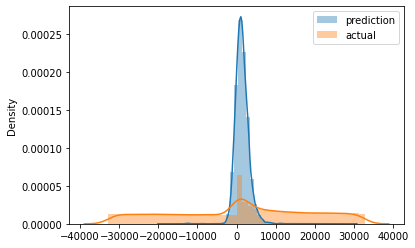

In [28]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

# Create a ML pipeline

In [29]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("russiaWorldTrade")

2022/09/02 00:12:16 INFO mlflow.tracking.fluent: Experiment with name 'russiaWorldTrade' does not exist. Creating a new experiment.


<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='russiaWorldTrade', tags={}>

In [30]:
df_train = read_parquet('./data/train_df.parquet')
df_valid = read_parquet('./data/valid_df.parquet')

In [31]:
df_valid

,Year,Aggregate Level,Reporter ISO,Partner,Partner ISO,Commodity Code,Commodity,Qty Unit,Qty,Netweight (kg),Trade Value (US$),Continent,Region
15,2016,2,RUS,Cayman Isds,CYM,68.0,Non-ferrous metals,No Quantity,0.0,0.0,11575,Americas,West Indies
16,2017,2,RUS,Cayman Isds,CYM,68.0,Non-ferrous metals,No Quantity,0.0,0.0,29654,Americas,West Indies
17,2017,2,RUS,Cayman Isds,CYM,89.0,"Miscellaneous manufactured articles, n.e.s.",No Quantity,0.0,0.0,5398,Americas,West Indies
18,2018,2,RUS,Cayman Isds,CYM,68.0,Non-ferrous metals,No Quantity,0.0,0.0,-21365,Americas,West Indies
19,2018,2,RUS,Cayman Isds,CYM,89.0,"Miscellaneous manufactured articles, n.e.s.",No Quantity,0.0,0.0,1279,Americas,West Indies
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384530,2020,2,RUS,Zimbabwe,ZWE,77.0,"Electrical machinery, apparatus and appliances...",No Quantity,0.0,0.0,976,Africa,Southern Africa
1384531,2020,2,RUS,Zimbabwe,ZWE,87.0,"Professional, scientific and controlling instr...",No Quantity,0.0,0.0,-27292,Africa,Southern Africa
1384532,2020,2,RUS,Zimbabwe,ZWE,88.0,"Photographic apparatus, equipment and supplies...",No Quantity,0.0,0.0,361,Africa,Southern Africa
1384533,2020,2,RUS,Zimbabwe,ZWE,89.0,"Miscellaneous manufactured articles, n.e.s.",No Quantity,0.0,0.0,4877,Africa,Southern Africa


In [32]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Alessandro")

    mlflow.log_param("train-data-path", "./data/train_df.parquet")
    mlflow.log_param("valid-data-path", "./data/valid_df.parquet")


    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")
    # with mlflow 1.28.0 MlflowException: The configured tracking uri scheme: 'sqlite' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}
    # mlflow db update
    # mlflow db upgrade sqlite:///mlflow.db

In [33]:
import xgboost as xgb
# Method to find the best hyperparams
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope



In [34]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [35]:
def objective(params):
  with mlflow.start_run():

    mlflow.set_tag("developer", "Alessandro")
    mlflow.set_tag("model", "xgboost")
    # mlflow.log_params(params) # Using mlflow.xgboost.autolog() later
    # mlflow.log_param("train-data-path", "./data/train_df.parquet")
    # mlflow.log_param("valid-data-path", "./data/valid_df.parquet")

    booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")
    
    return {'loss': rmse, 'status': STATUS_OK}
        
    # #alpha = 0.1
    # mlflow.log_param("alpha", alpha)
    # lr = Lasso(alpha)
    # lr.fit(X_train, y_train)

    # y_pred = lr.predict(X_val)
    # rmse = mean_squared_error(y_val, y_pred, squared=False)
    # mlflow.log_metric("rmse", rmse)

                

In [36]:
# See http://hyperopt.github.io/hyperopt/getting-started/search_spaces/ 
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # exp(-3), exp(0) - [0.05 -1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

mlflow.xgboost.autolog()

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

2022/09/02 00:17:16 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.


[00:17:16] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17541.62551                       
[1]	validation-rmse:17542.30488                       
[2]	validation-rmse:17550.83628                       
[3]	validation-rmse:17558.97114                       
[4]	validation-rmse:17570.60440                       
[5]	validation-rmse:17585.50230                       
[6]	validation-rmse:17601.46159                       
[7]	validation-rmse:17617.95783                       
[8]	validation-rmse:17633.62039                       
[9]	validation-rmse:17650.86309                       
[10]	validation-rmse:17662.31638                      
[11]	validation-rmse:17676.81587                      
[12]	validation-rmse:17694.53486                      
[13]	validation-rmse:17709.51096                      
[14]	validation-rmse:17722.93272                      
[15]	validation-rmse:17736.22888                      
[

2022/09/02 00:18:03 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2022/09/02 00:18:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/asurace/.local/share/virtualenvs/07-project-bZg0EPfU/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."



[00:18:05] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17675.05622                                              
[1]	validation-rmse:17800.34068                                              
[2]	validation-rmse:17884.77187                                              
[3]	validation-rmse:17997.23561                                              
[4]	validation-rmse:18043.74978                                              
[5]	validation-rmse:18101.97348                                              
[6]	validation-rmse:18162.81603                                              
[7]	validation-rmse:18249.01701                                              
[8]	validation-rmse:18292.33233                                              
[9]	validation-rmse:18346.25833                                              
[10]	validation-rmse:18389.26179                                             
[11]	validation-rmse:18

2022/09/02 00:18:19 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:18:21] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17547.30957                                              
[1]	validation-rmse:17556.67841                                              
[2]	validation-rmse:17575.36530                                              
[3]	validation-rmse:17598.07751                                              
[4]	validation-rmse:17629.97027                                              
[5]	validation-rmse:17665.47888                                              
[6]	validation-rmse:17697.15773                                              
[7]	validation-rmse:17737.28407                                              
[8]	validation-rmse:17777.65233                                              
[9]	validation-rmse:17811.04527                                              
[10]	validation-rmse:17853.07446                                             
[11]	validation-rmse:17

2022/09/02 00:20:20 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:20:22] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17528.22097                                              
[1]	validation-rmse:17519.59293                                              
[2]	validation-rmse:17513.31751                                              
[3]	validation-rmse:17512.09908                                              
[4]	validation-rmse:17516.99973                                              
[5]	validation-rmse:17520.05661                                              
[6]	validation-rmse:17520.44122                                              
[7]	validation-rmse:17521.34343                                              
[8]	validation-rmse:17525.70305                                              
[9]	validation-rmse:17525.77399                                              
[10]	validation-rmse:17527.94224                                             
[11]	validation-rmse:17

2022/09/02 00:20:30 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:20:31] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17530.74528                                              
[1]	validation-rmse:17536.86792                                              
[2]	validation-rmse:17556.96605                                              
[3]	validation-rmse:17575.48932                                              
[4]	validation-rmse:17596.73420                                              
[5]	validation-rmse:17615.25442                                              
[6]	validation-rmse:17630.85897                                              
[7]	validation-rmse:17644.68648                                              
[8]	validation-rmse:17656.27925                                              
[9]	validation-rmse:17670.35805                                              
[10]	validation-rmse:17683.08083                                             
[11]	validation-rmse:17

2022/09/02 00:21:04 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:21:06] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17528.80474                                              
[1]	validation-rmse:17521.22319                                              
[2]	validation-rmse:17515.85830                                              
[3]	validation-rmse:17516.47268                                              
[4]	validation-rmse:17519.24739                                              
[5]	validation-rmse:17519.31540                                              
[6]	validation-rmse:17519.52325                                              
[7]	validation-rmse:17520.00352                                              
[8]	validation-rmse:17521.85860                                              
[9]	validation-rmse:17522.75558                                              
[10]	validation-rmse:17523.84179                                             
[11]	validation-rmse:17

2022/09/02 00:21:15 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:21:17] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18175.55828                                           
[1]	validation-rmse:18806.52844                                           
[2]	validation-rmse:19213.41512                                           
[3]	validation-rmse:19531.91045                                           
[4]	validation-rmse:19772.07144                                           
[5]	validation-rmse:20102.14526                                           
[6]	validation-rmse:20351.97325                                           
[7]	validation-rmse:20448.93598                                           
[8]	validation-rmse:20585.95899                                           
[9]	validation-rmse:20714.84137                                           
[10]	validation-rmse:20740.13588                                          
[11]	validation-rmse:20814.38203                        

2022/09/02 00:22:25 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:22:27] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17530.94705                                           
[1]	validation-rmse:17541.11056                                           
[2]	validation-rmse:17558.39738                                           
[3]	validation-rmse:17576.73113                                           
[4]	validation-rmse:17588.91875                                           
[5]	validation-rmse:17607.46816                                           
[6]	validation-rmse:17621.38992                                           
[7]	validation-rmse:17637.78039                                           
[8]	validation-rmse:17647.08662                                           
[9]	validation-rmse:17660.98526                                           
[10]	validation-rmse:17680.15950                                          
[11]	validation-rmse:17689.74180                        

2022/09/02 00:22:55 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:22:56] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17543.44238                                           
[1]	validation-rmse:17541.37114                                           
[2]	validation-rmse:17541.91984                                           
[3]	validation-rmse:17542.52650                                           
[4]	validation-rmse:17545.62467                                           
[5]	validation-rmse:17547.31808                                           
[6]	validation-rmse:17549.39015                                           
[7]	validation-rmse:17554.15894                                           
[8]	validation-rmse:17557.75375                                           
[9]	validation-rmse:17561.10183                                           
[10]	validation-rmse:17562.83134                                          
[11]	validation-rmse:17568.02141                        

2022/09/02 00:23:35 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:23:37] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17587.27944                                           
[1]	validation-rmse:17708.60756                                           
[2]	validation-rmse:17873.84765                                           
[3]	validation-rmse:18032.02066                                           
[4]	validation-rmse:18220.15315                                           
[5]	validation-rmse:18349.75309                                           
[6]	validation-rmse:18485.21269                                           
[7]	validation-rmse:18612.19682                                           
[8]	validation-rmse:18803.80217                                           
[9]	validation-rmse:18896.57134                                           
[10]	validation-rmse:19067.30857                                          
[11]	validation-rmse:19198.01387                        

2022/09/02 00:25:17 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:25:19] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17639.44851                                            
[1]	validation-rmse:17727.17981                                            
[2]	validation-rmse:17853.93108                                            
[3]	validation-rmse:17914.68510                                            
[4]	validation-rmse:17954.89749                                            
[5]	validation-rmse:17993.14563                                            
[6]	validation-rmse:18043.15384                                            
[7]	validation-rmse:18087.89092                                            
[8]	validation-rmse:18131.75063                                            
[9]	validation-rmse:18143.56531                                            
[10]	validation-rmse:18172.19691                                           
[11]	validation-rmse:18233.64369             

2022/09/02 00:25:47 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:25:48] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17542.72031                                            
[1]	validation-rmse:17538.61269                                            
[2]	validation-rmse:17535.24870                                            
[3]	validation-rmse:17533.27398                                            
[4]	validation-rmse:17531.56909                                            
[5]	validation-rmse:17529.84971                                            
[6]	validation-rmse:17528.95695                                            
[7]	validation-rmse:17527.99359                                            
[8]	validation-rmse:17527.12705                                            
[9]	validation-rmse:17526.91748                                            
[10]	validation-rmse:17526.23564                                           
[11]	validation-rmse:17525.22160             

2022/09/02 00:26:03 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:26:05] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17542.43971                                              
[1]	validation-rmse:17547.54084                                              
[2]	validation-rmse:17557.22568                                              
[3]	validation-rmse:17576.13019                                              
[4]	validation-rmse:17598.01560                                              
[5]	validation-rmse:17623.86215                                              
[6]	validation-rmse:17649.33531                                              
[7]	validation-rmse:17677.31540                                              
[8]	validation-rmse:17695.06381                                              
[9]	validation-rmse:17718.63832                                              
[10]	validation-rmse:17745.67226                                             
[11]	validation-rmse:17

2022/09/02 00:27:45 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:27:47] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17597.05024                                              
[1]	validation-rmse:17718.05644                                              
[2]	validation-rmse:17823.75910                                              
[3]	validation-rmse:17916.79290                                              
[4]	validation-rmse:18010.10802                                              
[5]	validation-rmse:18114.13495                                              
[6]	validation-rmse:18231.85753                                              
[7]	validation-rmse:18297.61653                                              
[8]	validation-rmse:18347.94790                                              
[9]	validation-rmse:18424.06514                                              
[10]	validation-rmse:18489.96588                                             
[11]	validation-rmse:18

2022/09/02 00:29:31 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:29:33] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17564.14710                                              
[1]	validation-rmse:17639.96305                                              
[2]	validation-rmse:17716.83892                                              
[3]	validation-rmse:17743.88398                                              
[4]	validation-rmse:17772.11991                                              
[5]	validation-rmse:17784.09601                                              
[6]	validation-rmse:17821.18934                                              
[7]	validation-rmse:17859.06801                                              
[8]	validation-rmse:17868.98909                                              
[9]	validation-rmse:17872.22795                                              
[10]	validation-rmse:17871.02960                                             
[11]	validation-rmse:17

2022/09/02 00:30:14 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:30:15] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17989.02315                                              
[1]	validation-rmse:18751.56908                                              
[2]	validation-rmse:19398.72309                                              
[3]	validation-rmse:20111.11057                                              
[4]	validation-rmse:20465.13361                                              
[5]	validation-rmse:20925.97621                                              
[6]	validation-rmse:21361.09944                                              
[7]	validation-rmse:21743.65480                                              
[8]	validation-rmse:22076.33704                                              
[9]	validation-rmse:22330.19639                                              
[10]	validation-rmse:22482.82684                                             
[11]	validation-rmse:22

2022/09/02 00:32:43 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:32:44] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17628.79943                                              
[1]	validation-rmse:17730.71897                                              
[2]	validation-rmse:17787.81493                                              
[3]	validation-rmse:17885.74084                                              
[4]	validation-rmse:17934.39592                                              
[5]	validation-rmse:18001.40123                                              
[6]	validation-rmse:18073.53709                                              
[7]	validation-rmse:18129.58930                                              
[8]	validation-rmse:18183.67730                                              
[9]	validation-rmse:18212.95806                                              
[10]	validation-rmse:18229.86343                                             
[11]	validation-rmse:18

2022/09/02 00:33:00 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:33:01] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18369.47803                                              
[1]	validation-rmse:19189.72033                                              
[2]	validation-rmse:20000.02013                                              
[3]	validation-rmse:20513.01081                                              
[4]	validation-rmse:21143.16582                                              
[5]	validation-rmse:21593.44329                                              
[6]	validation-rmse:21973.95178                                              
[7]	validation-rmse:22374.71953                                              
[8]	validation-rmse:22726.60913                                              
[9]	validation-rmse:22925.29050                                              
[10]	validation-rmse:23102.81211                                             
[11]	validation-rmse:23

2022/09/02 00:35:22 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:35:24] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17550.23948                                              
[1]	validation-rmse:17587.18039                                              
[2]	validation-rmse:17603.77010                                              
[3]	validation-rmse:17646.38361                                              
[4]	validation-rmse:17692.72891                                              
[5]	validation-rmse:17725.08703                                              
[6]	validation-rmse:17762.69157                                              
[7]	validation-rmse:17798.56369                                              
[8]	validation-rmse:17839.38111                                              
[9]	validation-rmse:17878.50789                                              
[10]	validation-rmse:17916.23195                                             
[11]	validation-rmse:17

2022/09/02 00:36:11 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:36:12] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17531.46319                                              
[1]	validation-rmse:17522.69010                                              
[2]	validation-rmse:17519.44834                                              
[3]	validation-rmse:17516.50233                                              
[4]	validation-rmse:17515.67810                                              
[5]	validation-rmse:17516.73649                                              
[6]	validation-rmse:17518.92140                                              
[7]	validation-rmse:17518.80990                                              
[8]	validation-rmse:17518.98084                                              
[9]	validation-rmse:17520.25399                                              
[10]	validation-rmse:17523.19753                                             
[11]	validation-rmse:17

2022/09/02 00:36:22 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:36:24] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17540.42460                                              
[1]	validation-rmse:17534.37688                                              
[2]	validation-rmse:17529.33430                                              
[3]	validation-rmse:17526.21790                                              
[4]	validation-rmse:17523.26511                                              
[5]	validation-rmse:17521.16360                                              
[6]	validation-rmse:17519.38785                                              
[7]	validation-rmse:17517.81821                                              
[8]	validation-rmse:17517.20912                                              
[9]	validation-rmse:17516.48802                                              
[10]	validation-rmse:17515.95368                                             
[11]	validation-rmse:17

2022/09/02 00:36:34 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:36:36] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17541.11126                                               
[1]	validation-rmse:17536.93800                                               
[2]	validation-rmse:17535.51180                                               
[3]	validation-rmse:17534.36306                                               
[4]	validation-rmse:17534.93091                                               
[5]	validation-rmse:17533.02727                                               
[6]	validation-rmse:17533.72319                                               
[7]	validation-rmse:17534.41688                                               
[8]	validation-rmse:17534.03945                                               
[9]	validation-rmse:17536.45955                                               
[10]	validation-rmse:17538.84767                                              
[11]	validat

2022/09/02 00:36:51 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:37:03] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17545.82184                                               
[1]	validation-rmse:17556.84475                                               
[2]	validation-rmse:17567.29019                                               
[3]	validation-rmse:17582.06194                                               
[4]	validation-rmse:17593.49153                                               
[5]	validation-rmse:17606.19726                                               
[6]	validation-rmse:17624.06590                                               
[7]	validation-rmse:17636.61475                                               
[8]	validation-rmse:17648.31962                                               
[9]	validation-rmse:17663.48272                                               
[10]	validation-rmse:17676.51873                                              
[11]	validat

2022/09/02 00:37:39 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:37:41] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17544.06811                                               
[1]	validation-rmse:17541.10790                                               
[2]	validation-rmse:17539.04098                                               
[3]	validation-rmse:17537.65432                                               
[4]	validation-rmse:17536.51281                                               
[5]	validation-rmse:17536.57885                                               
[6]	validation-rmse:17535.97112                                               
[7]	validation-rmse:17535.66786                                               
[8]	validation-rmse:17535.52731                                               
[9]	validation-rmse:17535.84714                                               
[10]	validation-rmse:17535.65039                                              
[11]	validat

2022/09/02 00:37:58 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:38:00] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17541.09619                                               
[1]	validation-rmse:17535.91070                                               
[2]	validation-rmse:17531.55029                                               
[3]	validation-rmse:17528.80101                                               
[4]	validation-rmse:17525.90335                                               
[5]	validation-rmse:17523.51694                                               
[6]	validation-rmse:17521.81818                                               
[7]	validation-rmse:17520.73325                                               
[8]	validation-rmse:17520.10739                                               
[9]	validation-rmse:17519.80870                                               
[10]	validation-rmse:17519.51104                                              
[11]	validat

2022/09/02 00:38:09 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:38:12] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17540.97739                                               
[1]	validation-rmse:17539.89632                                               
[2]	validation-rmse:17540.54214                                               
[3]	validation-rmse:17545.44472                                               
[4]	validation-rmse:17551.85679                                               
[5]	validation-rmse:17555.63965                                               
[6]	validation-rmse:17562.53916                                               
[7]	validation-rmse:17568.04298                                               
[8]	validation-rmse:17573.66877                                               
[9]	validation-rmse:17579.50831                                               
[10]	validation-rmse:17586.12779                                              
[11]	validat

2022/09/02 00:38:45 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:38:47] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17537.65705                                               
[1]	validation-rmse:17530.54726                                               
[2]	validation-rmse:17524.44772                                               
[3]	validation-rmse:17520.87619                                               
[4]	validation-rmse:17518.02558                                               
[5]	validation-rmse:17516.75439                                               
[6]	validation-rmse:17515.26585                                               
[7]	validation-rmse:17514.38611                                               
[8]	validation-rmse:17512.73924                                               
[9]	validation-rmse:17512.46574                                               
[10]	validation-rmse:17513.36439                                              
[11]	validat

2022/09/02 00:38:55 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:38:57] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17535.69655                                               
[1]	validation-rmse:17528.57120                                               
[2]	validation-rmse:17526.87885                                               
[3]	validation-rmse:17525.36989                                               
[4]	validation-rmse:17527.66547                                               
[5]	validation-rmse:17531.23533                                               
[6]	validation-rmse:17531.40703                                               
[7]	validation-rmse:17534.52399                                               
[8]	validation-rmse:17537.08568                                               
[9]	validation-rmse:17539.90312                                               
[10]	validation-rmse:17547.44531                                              
[11]	validat

2022/09/02 00:39:28 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:39:29] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17536.86530                                               
[1]	validation-rmse:17528.74030                                               
[2]	validation-rmse:17524.97227                                               
[3]	validation-rmse:17522.60129                                               
[4]	validation-rmse:17520.96667                                               
[5]	validation-rmse:17518.49068                                               
[6]	validation-rmse:17517.67072                                               
[7]	validation-rmse:17519.18324                                               
[8]	validation-rmse:17518.32200                                               
[9]	validation-rmse:17519.39186                                               
[10]	validation-rmse:17518.51389                                              
[11]	validat

2022/09/02 00:39:46 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:39:47] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17532.16363                                               
[1]	validation-rmse:17524.60594                                               
[2]	validation-rmse:17526.59386                                               
[3]	validation-rmse:17531.05285                                               
[4]	validation-rmse:17537.29847                                               
[5]	validation-rmse:17541.94052                                               
[6]	validation-rmse:17547.43799                                               
[7]	validation-rmse:17551.76446                                               
[8]	validation-rmse:17559.88882                                               
[9]	validation-rmse:17563.82295                                               
[10]	validation-rmse:17569.53401                                              
[11]	validat

2022/09/02 00:40:27 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:40:28] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17540.43070                                               
[1]	validation-rmse:17535.12033                                               
[2]	validation-rmse:17530.01960                                               
[3]	validation-rmse:17526.46712                                               
[4]	validation-rmse:17524.97601                                               
[5]	validation-rmse:17522.94572                                               
[6]	validation-rmse:17522.47058                                               
[7]	validation-rmse:17522.87641                                               
[8]	validation-rmse:17522.33702                                               
[9]	validation-rmse:17523.24475                                               
[10]	validation-rmse:17523.09024                                              
[11]	validat

2022/09/02 00:40:53 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:40:55] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17541.01702                                               
[1]	validation-rmse:17553.14393                                               
[2]	validation-rmse:17569.91143                                               
[3]	validation-rmse:17592.74481                                               
[4]	validation-rmse:17616.25812                                               
[5]	validation-rmse:17641.38043                                               
[6]	validation-rmse:17659.81624                                               
[7]	validation-rmse:17683.86484                                               
[8]	validation-rmse:17700.29329                                               
[9]	validation-rmse:17725.64155                                               
[10]	validation-rmse:17743.12202                                              
[11]	validat

2022/09/02 00:42:00 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:42:02] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17555.31983                                               
[1]	validation-rmse:17598.88116                                               
[2]	validation-rmse:17639.08085                                               
[3]	validation-rmse:17672.48152                                               
[4]	validation-rmse:17697.98927                                               
[5]	validation-rmse:17751.32168                                               
[6]	validation-rmse:17786.30893                                               
[7]	validation-rmse:17821.89553                                               
[8]	validation-rmse:17856.56576                                               
[9]	validation-rmse:17895.30125                                               
[10]	validation-rmse:17935.20204                                              
[11]	validat

2022/09/02 00:42:54 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:42:56] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17534.37497                                               
[1]	validation-rmse:17527.32664                                               
[2]	validation-rmse:17522.44547                                               
[3]	validation-rmse:17520.59986                                               
[4]	validation-rmse:17522.38593                                               
[5]	validation-rmse:17520.93098                                               
[6]	validation-rmse:17520.41431                                               
[7]	validation-rmse:17519.82772                                               
[8]	validation-rmse:17520.90419                                               
[9]	validation-rmse:17521.31954                                               
[10]	validation-rmse:17523.53452                                              
[11]	validat

2022/09/02 00:43:14 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:43:15] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17523.22673                                               
[1]	validation-rmse:17518.12513                                               
[2]	validation-rmse:17516.21953                                               
[3]	validation-rmse:17516.51832                                               
[4]	validation-rmse:17515.00830                                               
[5]	validation-rmse:17516.72022                                               
[6]	validation-rmse:17519.39073                                               
[7]	validation-rmse:17520.38241                                               
[8]	validation-rmse:17524.31773                                               
[9]	validation-rmse:17525.98005                                               
[10]	validation-rmse:17525.26288                                              
[11]	validat

2022/09/02 00:43:24 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:43:25] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17541.58034                                               
[1]	validation-rmse:17538.01871                                               
[2]	validation-rmse:17535.44831                                               
[3]	validation-rmse:17534.98984                                               
[4]	validation-rmse:17535.09176                                               
[5]	validation-rmse:17535.74560                                               
[6]	validation-rmse:17536.89124                                               
[7]	validation-rmse:17538.24390                                               
[8]	validation-rmse:17538.38874                                               
[9]	validation-rmse:17540.87778                                               
[10]	validation-rmse:17542.96387                                              
[11]	validat

2022/09/02 00:43:46 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:43:47] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17543.03196                                               
[1]	validation-rmse:17539.18109                                               
[2]	validation-rmse:17537.07548                                               
[3]	validation-rmse:17535.42800                                               
[4]	validation-rmse:17534.62188                                               
[5]	validation-rmse:17534.89119                                               
[6]	validation-rmse:17535.64719                                               
[7]	validation-rmse:17536.22365                                               
[8]	validation-rmse:17537.51545                                               
[9]	validation-rmse:17538.01680                                               
[10]	validation-rmse:17539.30540                                              
[11]	validat

2022/09/02 00:44:25 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:44:27] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17570.80125                                               
[1]	validation-rmse:17629.88660                                               
[2]	validation-rmse:17692.06429                                               
[3]	validation-rmse:17746.53548                                               
[4]	validation-rmse:17797.98963                                               
[5]	validation-rmse:17871.18248                                               
[6]	validation-rmse:17924.24862                                               
[7]	validation-rmse:17974.76141                                               
[8]	validation-rmse:18050.58220                                               
[9]	validation-rmse:18099.62356                                               
[10]	validation-rmse:18146.75165                                              
[11]	validat

2022/09/02 00:45:12 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:45:13] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17537.22929                                               
[1]	validation-rmse:17528.76644                                               
[2]	validation-rmse:17523.51124                                               
[3]	validation-rmse:17523.56038                                               
[4]	validation-rmse:17525.74117                                               
[5]	validation-rmse:17524.99613                                               
[6]	validation-rmse:17526.13962                                               
[7]	validation-rmse:17529.55570                                               
[8]	validation-rmse:17531.42897                                               
[9]	validation-rmse:17533.71811                                               
[10]	validation-rmse:17537.05408                                              
[11]	validat

2022/09/02 00:45:39 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:45:41] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17534.10721                                               
[1]	validation-rmse:17525.50157                                               
[2]	validation-rmse:17521.15830                                               
[3]	validation-rmse:17522.18432                                               
[4]	validation-rmse:17520.09382                                               
[5]	validation-rmse:17524.38716                                               
[6]	validation-rmse:17524.07758                                               
[7]	validation-rmse:17528.62098                                               
[8]	validation-rmse:17535.53634                                               
[9]	validation-rmse:17536.46568                                               
[10]	validation-rmse:17540.41657                                              
[11]	validat

2022/09/02 00:46:05 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:46:07] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17554.60901                                               
[1]	validation-rmse:17602.56774                                               
[2]	validation-rmse:17650.18416                                               
[3]	validation-rmse:17675.76547                                               
[4]	validation-rmse:17708.52470                                               
[5]	validation-rmse:17758.96873                                               
[6]	validation-rmse:17802.88044                                               
[7]	validation-rmse:17838.63814                                               
[8]	validation-rmse:17872.02986                                               
[9]	validation-rmse:17907.22786                                               
[10]	validation-rmse:17940.23194                                              
[11]	validat

2022/09/02 00:46:59 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:47:00] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17543.91962                                               
[1]	validation-rmse:17561.69626                                               
[2]	validation-rmse:17594.33445                                               
[3]	validation-rmse:17618.69195                                               
[4]	validation-rmse:17653.57711                                               
[5]	validation-rmse:17694.70990                                               
[6]	validation-rmse:17733.77647                                               
[7]	validation-rmse:17773.90216                                               
[8]	validation-rmse:17806.59374                                               
[9]	validation-rmse:17839.94243                                               
[10]	validation-rmse:17886.01216                                              
[11]	validat

2022/09/02 00:48:08 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:48:10] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17544.06626                                               
[1]	validation-rmse:17541.02763                                               
[2]	validation-rmse:17538.29477                                               
[3]	validation-rmse:17536.20385                                               
[4]	validation-rmse:17534.41495                                               
[5]	validation-rmse:17533.00396                                               
[6]	validation-rmse:17531.52515                                               
[7]	validation-rmse:17530.29890                                               
[8]	validation-rmse:17529.01296                                               
[9]	validation-rmse:17527.40714                                               
[10]	validation-rmse:17526.40170                                              
[11]	validat

2022/09/02 00:48:26 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:48:28] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17542.98194                                               
[1]	validation-rmse:17541.95569                                               
[2]	validation-rmse:17540.73595                                               
[3]	validation-rmse:17544.21801                                               
[4]	validation-rmse:17543.89616                                               
[5]	validation-rmse:17548.77161                                               
[6]	validation-rmse:17554.91555                                               
[7]	validation-rmse:17559.03992                                               
[8]	validation-rmse:17561.95560                                               
[9]	validation-rmse:17568.54922                                               
[10]	validation-rmse:17573.10676                                              
[11]	validat

2022/09/02 00:48:52 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:48:54] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17541.09521                                               
[1]	validation-rmse:17535.54963                                               
[2]	validation-rmse:17530.62561                                               
[3]	validation-rmse:17527.64449                                               
[4]	validation-rmse:17524.79234                                               
[5]	validation-rmse:17522.59791                                               
[6]	validation-rmse:17521.49119                                               
[7]	validation-rmse:17520.10045                                               
[8]	validation-rmse:17518.72641                                               
[9]	validation-rmse:17517.85615                                               
[10]	validation-rmse:17516.66463                                              
[11]	validat

2022/09/02 00:49:05 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:49:06] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17546.00202                                               
[1]	validation-rmse:17547.34499                                               
[2]	validation-rmse:17552.31453                                               
[3]	validation-rmse:17558.70043                                               
[4]	validation-rmse:17574.99702                                               
[5]	validation-rmse:17587.10994                                               
[6]	validation-rmse:17600.31986                                               
[7]	validation-rmse:17608.18999                                               
[8]	validation-rmse:17623.97396                                               
[9]	validation-rmse:17629.71230                                               
[10]	validation-rmse:17638.71524                                              
[11]	validat

2022/09/02 00:49:45 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:49:46] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17545.22137                                               
[1]	validation-rmse:17545.31440                                               
[2]	validation-rmse:17547.93315                                               
[3]	validation-rmse:17550.75490                                               
[4]	validation-rmse:17551.69241                                               
[5]	validation-rmse:17554.74350                                               
[6]	validation-rmse:17556.74597                                               
[7]	validation-rmse:17560.15622                                               
[8]	validation-rmse:17565.08989                                               
[9]	validation-rmse:17570.95479                                               
[10]	validation-rmse:17574.32256                                              
[11]	validat

2022/09/02 00:50:21 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:50:22] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17548.29574                                               
[1]	validation-rmse:17561.33374                                               
[2]	validation-rmse:17583.66958                                               
[3]	validation-rmse:17604.84151                                               
[4]	validation-rmse:17633.04204                                               
[5]	validation-rmse:17652.31763                                               
[6]	validation-rmse:17674.60994                                               
[7]	validation-rmse:17702.72153                                               
[8]	validation-rmse:17727.44756                                               
[9]	validation-rmse:17757.31574                                               
[10]	validation-rmse:17795.38706                                              
[11]	validat

2022/09/02 00:51:33 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:51:35] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17586.91828                                               
[1]	validation-rmse:17700.54304                                               
[2]	validation-rmse:17818.60280                                               
[3]	validation-rmse:17965.12641                                               
[4]	validation-rmse:18066.64682                                               
[5]	validation-rmse:18189.12507                                               
[6]	validation-rmse:18305.63681                                               
[7]	validation-rmse:18410.63437                                               
[8]	validation-rmse:18527.30025                                               
[9]	validation-rmse:18606.00755                                               
[10]	validation-rmse:18729.60014                                              
[11]	validat

2022/09/02 00:52:57 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



[00:52:59] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17714.48614                                               
[1]	validation-rmse:17933.65533                                               
[2]	validation-rmse:18126.05140                                               
[3]	validation-rmse:18260.45663                                               
[4]	validation-rmse:18483.51313                                               
[5]	validation-rmse:18623.93813                                               
[6]	validation-rmse:18738.40387                                               
[7]	validation-rmse:18858.31720                                               
[8]	validation-rmse:19031.76432                                               
[9]	validation-rmse:19157.63859                                               
[10]	validation-rmse:19291.10145                                              
[11]	validat

2022/09/02 00:54:03 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.



100%|██████████| 50/50 [36:47<00:00, 44.16s/trial, best loss: 17518.595703125]


In [37]:
# example of hyperopt-sklearn for the housing regression dataset
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from hpsklearn import HyperoptEstimator
from hpsklearn import any_regressor
from hpsklearn import any_preprocessing
from hyperopt import tpe
# load dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
dataframe = read_csv(url, header=None)
# split into input and output elements
data = dataframe.values
data = data.astype('float32')
X, y = data[:, :-1], data[:, -1]
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# define search
model = HyperoptEstimator(regressor=any_regressor('reg'), preprocessing=any_preprocessing('pre'), loss_fn=mean_absolute_error, algo=tpe.suggest, max_evals=50, trial_timeout=30)
# perform the search
model.fit(X_train, y_train)
# summarize performance
mae = model.score(X_test, y_test)
print("MAE: %.3f" % mae)
# summarize the best model
print(model.best_model())

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

2022/09/02 01:12:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a5c14c12ecf54b7a9387033602df9fa9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow



100%|██████████| 1/1 [00:30<00:00, 30.09s/trial, best loss=?]


AllTrialsFailed: 

In [36]:
# Find the best params looking for the lowest RMSE in MLFLOW and reuse the params here

mlflow.xgboost.autolog()

with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.08023673823188773,
        'max_depth': 5,
        'min_child_weight': 19.53568450887438,
        'objective': 'reg:linear',
        'reg_alpha': 0.026605630217501015,
        'reg_lambda': 0.0035016901628043395,
        'seed': 42
    }
    # mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")


[22:32:15] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17541.62221
[1]	validation-rmse:17536.57532
[2]	validation-rmse:17532.14525
[3]	validation-rmse:17528.75124
[4]	validation-rmse:17525.75745
[5]	validation-rmse:17523.29006
[6]	validation-rmse:17521.20714
[7]	validation-rmse:17519.57377
[8]	validation-rmse:17518.05814
[9]	validation-rmse:17516.88056
[10]	validation-rmse:17516.63146
[11]	validation-rmse:17515.95906
[12]	validation-rmse:17514.84065
[13]	validation-rmse:17514.49391
[14]	validation-rmse:17513.92245
[15]	validation-rmse:17514.47011
[16]	validation-rmse:17513.89354
[17]	validation-rmse:17513.59629
[18]	validation-rmse:17514.04319
[19]	validation-rmse:17514.25774
[20]	validation-rmse:17514.07178
[21]	validation-rmse:17514.16136
[22]	validation-rmse:17513.95868
[23]	validation-rmse:17514.47288
[24]	validation-rmse:17514.64325
[25]	validation-rmse:17514.62121
[26]	validation-rmse:17514.39811


In [35]:
# Try with different ML Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog() # This logs a lot of params directly in MLFLOW

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/train_df.parquet")
        mlflow.log_param("valid-data-path", "./data/valid_df.parquet")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

/home/asurace/.local/share/virtualenvs/07-project-bZg0EPfU/lib/python3.9/site-packages/sklearn/svm/_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
